# 1. Checking all the High Level Science Products will yield more planets


The Kepler/K2 motion is on timescales of ~6 hours and can cause flux variations of $\lesssim1\%$, making it a hinderance to planet hunting. There are several ways to detrend the Kepler/K2 motion, including but not limited to:

* Self Flat Fielding Tehchnique (e.g. Vanderburg and Johnson et al and the K2SFF pipeline)
* Pixel Level Decorrelation Method (e.g. Luger at al and the EVEREST pipeline)
* Gaussian Process Detrending (e.g. Aigrain et al and the K2SC pipeline)

Each of these methods has slightly different assumptions, and different strengths. If you are hunting for exoplanets in the Kepler/K2 data, make sure to search each of these products to maximise your chances of finding signals!

In this notebook, I will show you a **new K2 Planet Candidate** that has gone unreported. Candidate K2-43c has been unreported due to planet searches being limited to one technique.

K2-43b was reported in both
* [Dressing et al 2017](https://arxiv.org/pdf/1703.07416.pdf)
* [Crossfield et al 2016](https://arxiv.org/pdf/1607.05263.pdf)

Where both teams used the SFF technique to detrend the K2 motion.

K2-43b was discovered in K2 Campaign 1. In this early campaign, extremely short time scale variability was still present in the data, making the SFF method less effective. This variability was within a single exposure, slightly changing the PSF shape. This variability increased the noise, and so K2-43c went undiscovered. However, the PLD technique is still effective at removing noise on these extremely short timescales, and using PLD it is possible to find the signal of K2-43c.

Below, I go into details on how the planet candidate can be found.

## K2-43b

First, we can obtain the K2 data using `lightkurve`. In this case, I've written a short script to scrape the HLSPs available for this target, available in the `scripts.py` file. Below I download the data and plot up the two HLSPs.

In [2]:
import lightkurve as lk
from scripts import fetch_hlsps
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(lk.MPLSTYLE)

In [3]:
lcf = lk.search_lightcurvefile('EPIC 201205469').download()

Text(0.5,1,'EPIC 201205469 Campaign 1')

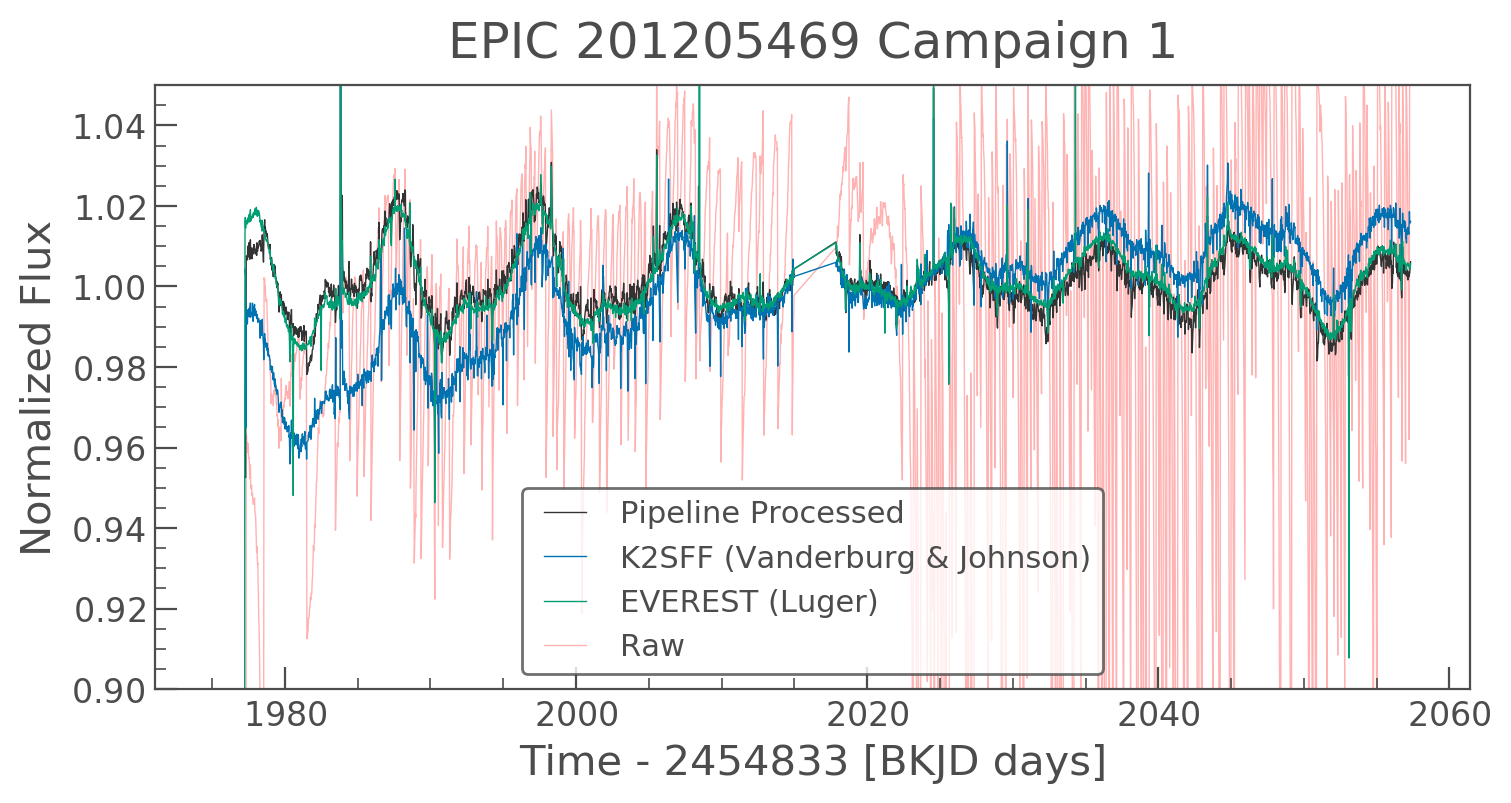

In [4]:
ax = lcf.PDCSAP_FLUX.remove_outliers(10).plot(label='Pipeline Processed')
hlsps = fetch_hlsps(lcf.PDCSAP_FLUX)
for hlsp in hlsps:
    hlsp.remove_outliers(10).plot(ax=ax)
lcf.SAP_FLUX.remove_outliers(10).plot(ax=ax, label='Raw', c='r', alpha=0.3, zorder=-10)

ax.set_ylim(0.9, 1.05)
ax.set_title('EPIC {} Campaign {}'.format(lcf.targetid, lcf.campaign))

Above are the pipeline data sets (black and red) and the K2SFF dataset (using the SFF technique) and the EVEREST dataset (using PLD). The period, duration and transit midpoint of the known confirmed planet are given below.

In [5]:
period_1, duration_1, t0_1 = 3.471341, 0.1, 1.67793192

We'll use the EVEREST dataset and remove the long term trends. (Here I'm using a Gaussian Process, you'll hear more 
about that in the next notebook). 

Below I use some `lightkurve` methods to clean up the light curve. 

In [9]:
lc1 = hlsps[1]
lc1.flux_err[~np.isfinite(lc1.flux_err)] = 0.0005
lc1 = lc1.remove_nans().normalize().remove_outliers(5)

In [10]:
ph = (lc1.time - t0_1)/period_1 % 1
out_of_transit = (ph > ((duration_1 * 1.5)/period_1)/2) & (ph < 1 - ((duration_1 * 1.5)/period_1)/2)

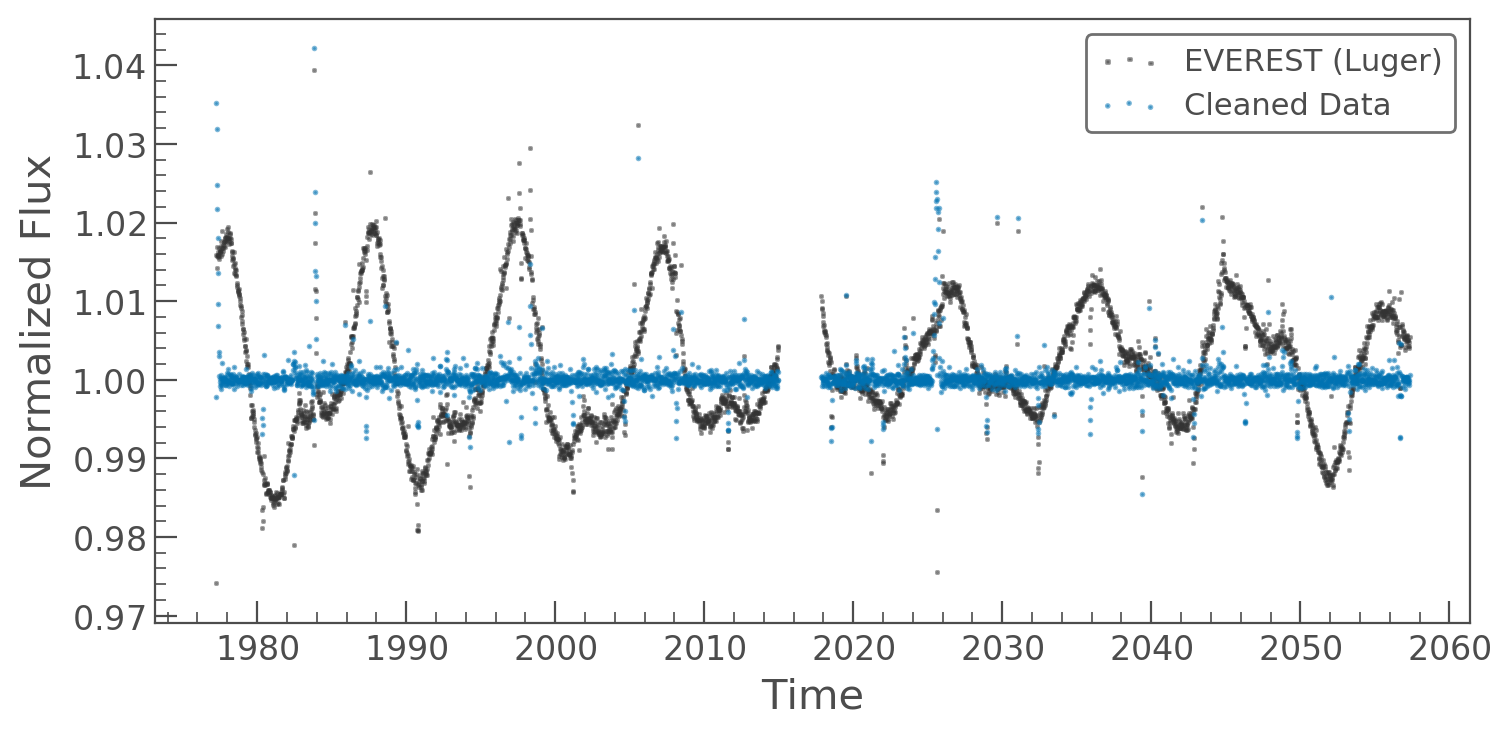

In [11]:
ax = lc1.scatter(alpha=0.5, marker='s')
lc1 = lc1.to_corrector('gp').correct(mask=~out_of_transit, timescale=2)
lc1.scatter(ax=ax, alpha=0.5, marker='o', label='Cleaned Data')

Now we have a flat light curve, we can us a Box Least Squares to find any remaining transiting planet signals. First we will mask out the known planet, to ensure we won't be confused by the known signal.

Using the `lightkurve` periodogram class we can see that there is a signal at 2.2 days!

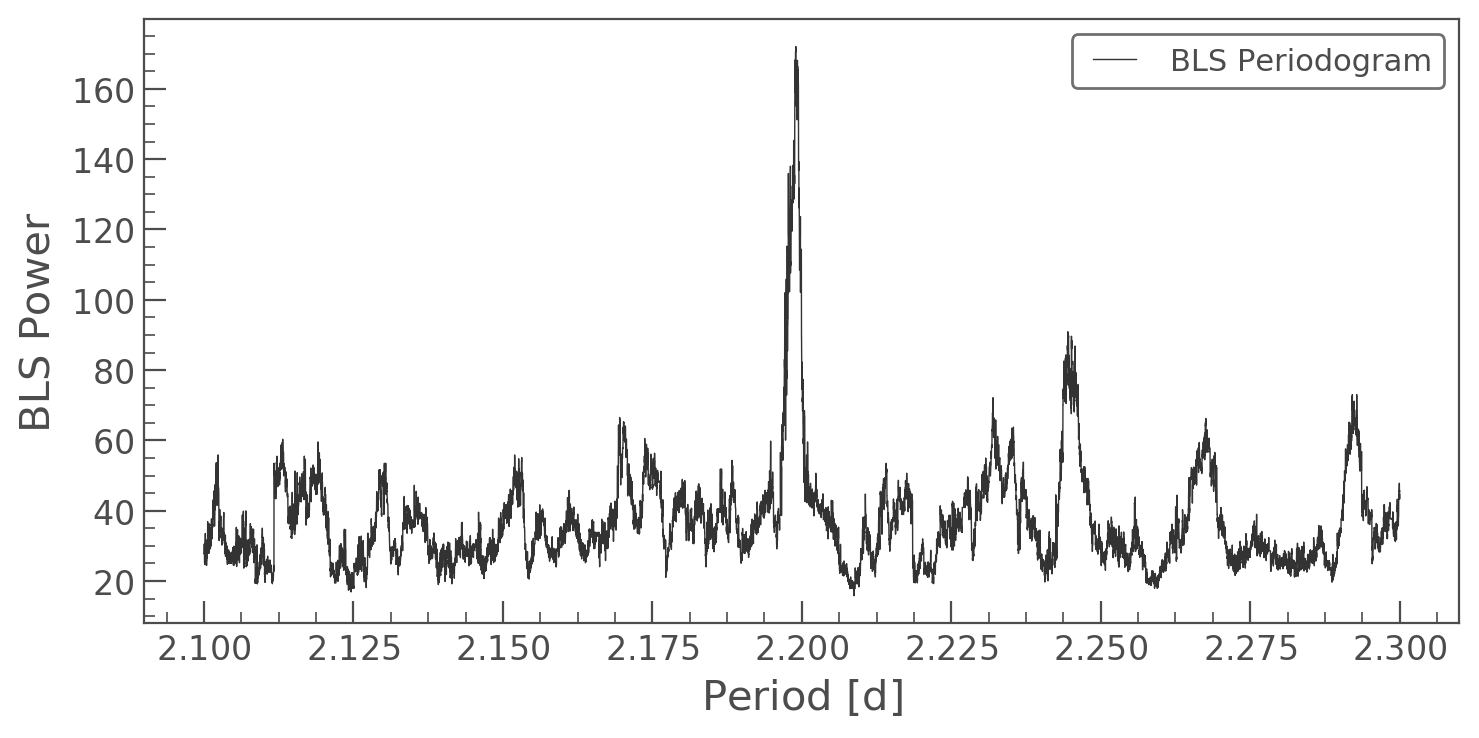

In [12]:
p = lc1[out_of_transit].to_periodogram(method='bls', duration=0.05, minimum_period=2.1, maximum_period=2.3, frequency_factor=0.1)
p.plot(label='BLS Periodogram')

Using the `Periodogram` class from above we can get the period, duration and transit midpoint for this new signal.

In [13]:
period_2, duration_2, t0_2 = p.period_at_max_power.value, 0.05, p.transit_time_at_max_power

Now we can fold both the K2SFF dataset and EVEREST dataset at the found period and duration, and see if the signal is really a planet.

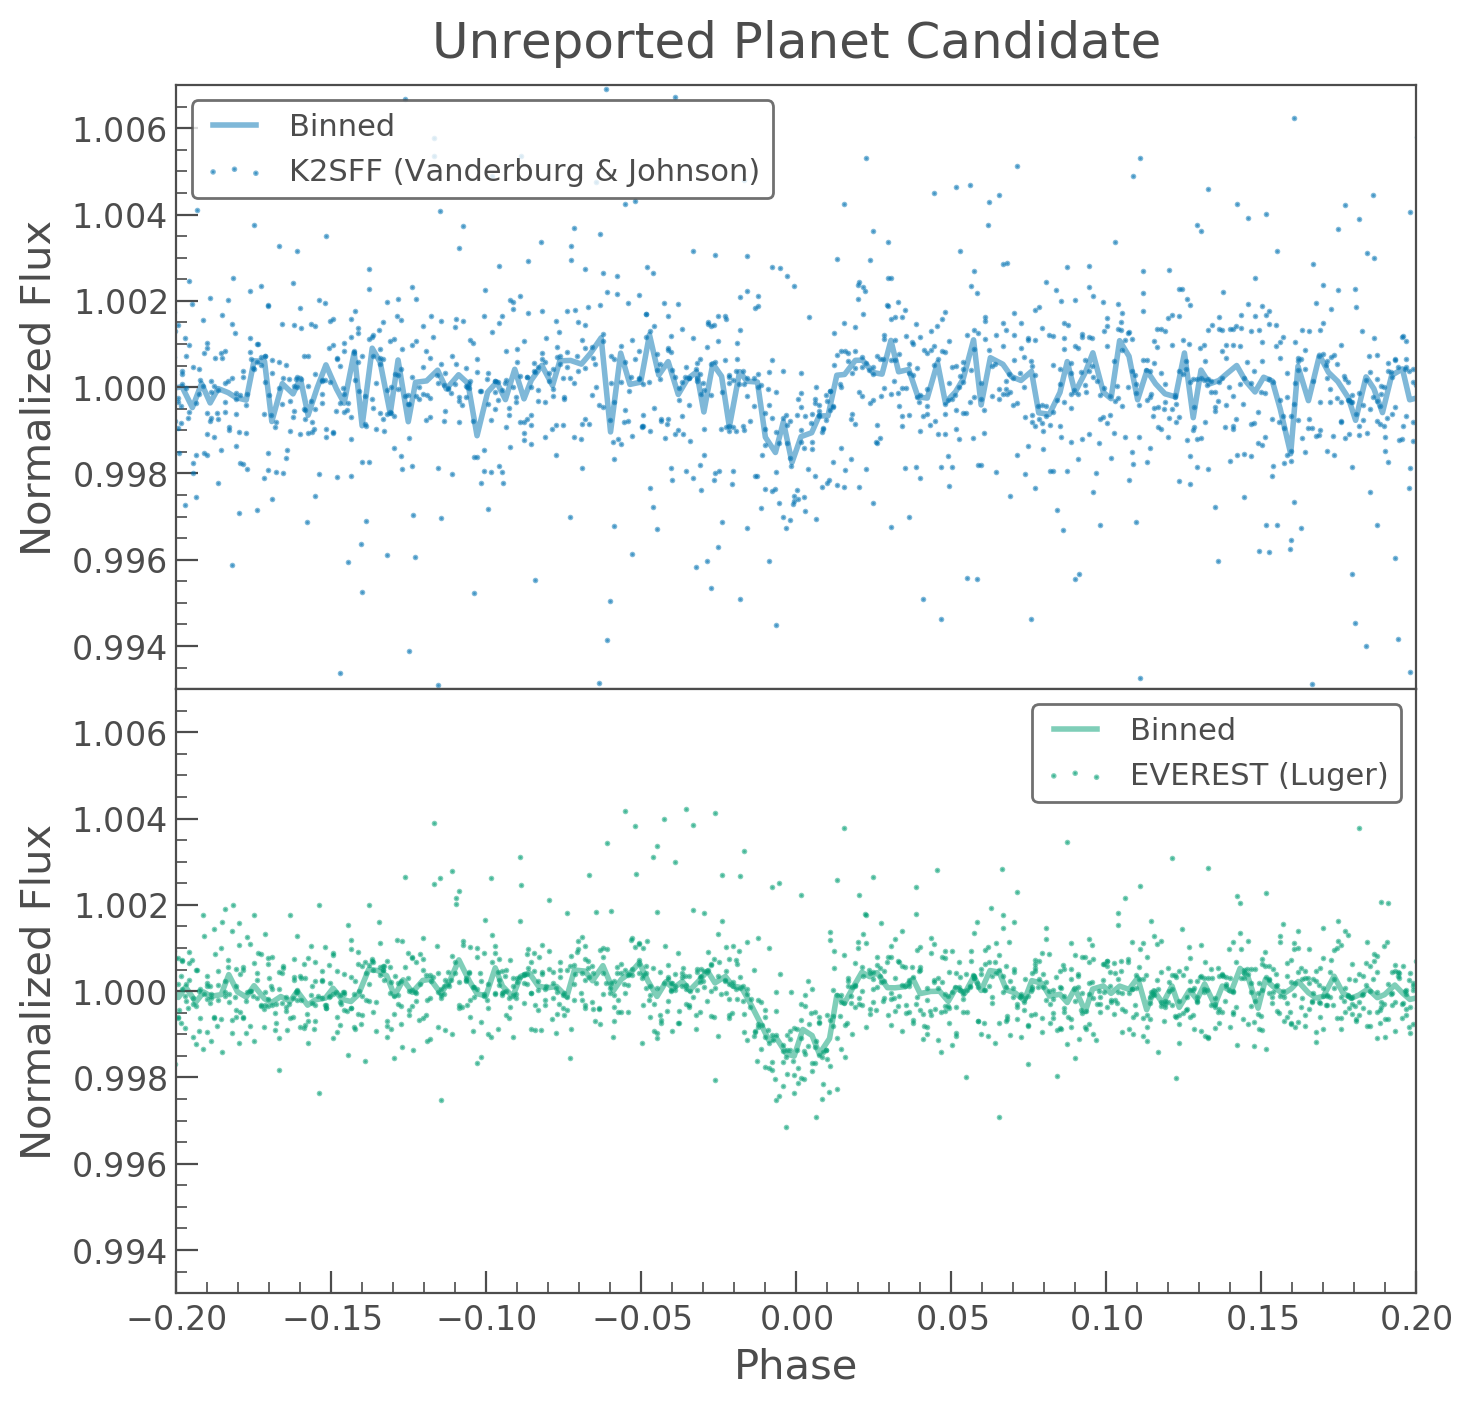

In [16]:
fig, ax = plt.subplots(2, figsize=(8, 8))
for idx, lc1 in enumerate(hlsps):
    # Mask planet 2
    lc1.flux_err[~np.isfinite(lc1.flux_err)] = 0.0005
    lc1 = lc1.remove_nans().normalize()
    lc1 = lc1[lc1.flux > 0.8]
    ph = (lc1.time - t0_1)/period_1 % 1
    out_of_transit = (ph > ((duration_1 * 1.5)/period_1)/2) & (ph < 1 - ((duration_1 * 1.5)/period_1)/2)
    
    lc1 = lc1.to_corrector('gp').correct(mask=~out_of_transit, timescale=2)
    lc1 = lc1[out_of_transit].remove_outliers(5)
    lc1.fold(period_2, t0_2).scatter(ax=ax[idx], c= 'C{}'.format(idx + 1), alpha=0.5, zorder=2)
    lc1.fold(period_2, t0_2).bin(10, 'median').plot(ax=ax[idx], c= 'C{}'.format(idx + 1), lw=2, alpha=0.5, label='Binned', zorder=1)

    ax[idx].set_xlim(-0.2, 0.2)
    ax[idx].set_ylim(0.993, 1.007)
    if idx < 1:
        ax[idx].set_xticks([])
    if idx == 0:
        ax[idx].set_title('Unreported Planet Candidate')
plt.subplots_adjust(hspace=0)

It looks like there is a strong signal in the EVEREST light curve, but there is slightly too much noise in the K2SFF light curve to detect it. For comparison, see the signal for K2-43b below:

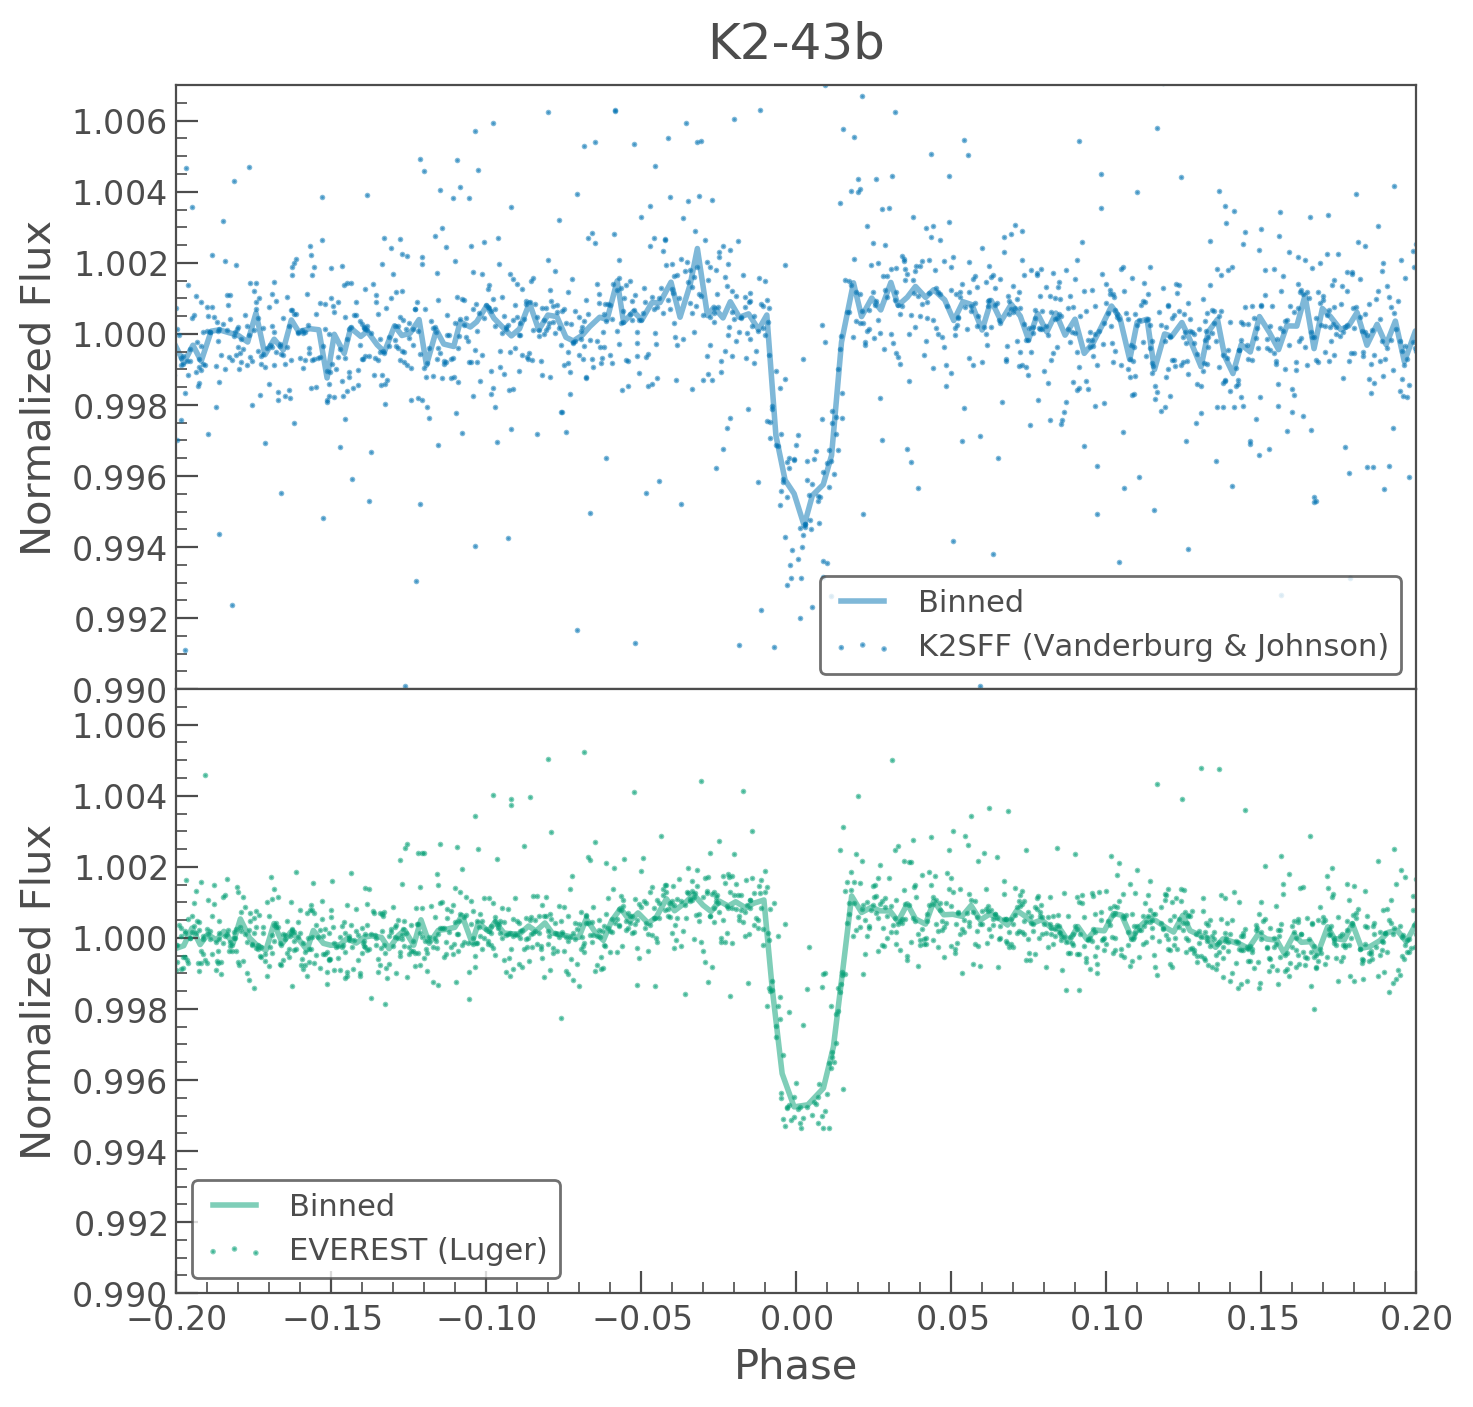

In [15]:
fig, ax = plt.subplots(2, figsize=(8, 8))
for idx, lc1 in enumerate(hlsps):
    # Mask planet 2
    lc1.flux_err[~np.isfinite(lc1.flux_err)] = 0.0005
    lc1 = lc1.remove_nans().normalize()
    lc1 = lc1[lc1.flux > 0.8]
    ph = (lc1.time - t0_2)/period_2 % 1
    out_of_transit = (ph > ((duration_2 * 1.5)/period_2)/2) & (ph < 1 - ((duration_2 * 1.5)/period_2)/2)
    
    lc1 = lc1.to_corrector('gp').correct(mask=~out_of_transit, timescale=2)
    lc1 = lc1[out_of_transit].remove_outliers(5)
    lc1.fold(period_1, t0_1).scatter(ax=ax[idx], c= 'C{}'.format(idx + 1), alpha=0.5, zorder=2)
    lc1.fold(period_1, t0_1).bin(10, 'median').plot(ax=ax[idx], c= 'C{}'.format(idx + 1), lw=2, alpha=0.5, label='Binned', zorder=1)

    ax[idx].set_xlim(-0.2, 0.2)
    ax[idx].set_ylim(0.99, 1.007)
    if idx < 1:
        ax[idx].set_xticks([])
    if idx == 0:
        ax[idx].set_title('K2-43b')
plt.subplots_adjust(hspace=0)

As you can see, using several detrending methods when hunting for exoplanets in K2 data can yield more planet candidates!